## PROYECTO MÓDULO 3: Optimización de Talento

#### A partir de un CSV con datos de trabajadores debemos tratar los datos siguiendo los siguientes pasos:

1. Averiguar por qué se han marchado las empleadas de la empresa.
2. Si queremos más información o pistas podemos preguntarle a Rocío
3. FASES: 
    1. Hacer un EDA
    2. Transformar los datos (limpieza de nulos, normalización, etc.)
    3. Visualización de datos (hacer gráficas en Python). 
    4. BONUS: Diseño de base de datos e insertar los datos en SQL. 
    5. BONUS: Creación de ETL, hacer funciones para automatizar el proceso. 
    6. Hacer una presentación:
        - **Introducción, objetivos, pasos y organización**
        - Parte central: **análisis de los gráficas, tablas...**
        - **¿Qué info podemos obtener de estos? ¿Consejos para la empresa? ¿Mejoras? ¿Encontramos correlación entre variables?**
        - **Retos y soluciones**
        - **Conclusiones**
4. Aplicar metodología Agile y Srum. **Rocío** va a ser la clienta final: **Product Owner**


### PARTE 4: VISUALIZACIÓN

In [1]:
#Importar librería
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Configuración de la visualización del DataFrame
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
#Lectura del CSV y transformación a DataFrame (df)
df=pd.read_csv("HR_RAW_v2.csv", index_col =0)
df.sample(5)

,numero_empleado,desvinculado,genero,edad,año_nacimiento,estado_civil,nivel_estudios,campo_estudios,frecuencia_viaje,distancia_domicilio,teletrabajo,tipo_jornada,formaciones_ultimo_año,trabajos_anteriores,años_en_activo,antigüedad_empresa,años_ultimo_ascenso,años_mismo_responsable,departamento,categoria,puesto,horas_extras,evaluacion_desempeño,tarifa_hora,tarifa_diaria,tarifa_mensual,ingreso_mensual,%_incremento_salarial,acceso_acciones_empresa,nivel_compromiso,nivel_satisfaccion_global,nivel_satisfaccion_trabajo,nivel_satisfaccion_relaciones,nivel_satisfaccion_conciliacion
1448,1865.0,No,male,29,1994,married,1,ns/nc,travel rarely,9.66,yes,part time,3,1,11.318934,1,0,0,sin asignar,1,human resources,No,3.0,87.0,352.0,15434,2804.0,11,0,2,4,2,4,3.0
1330,0.0,No,male,27,1996,married,3,Medical,non travel,4.83,yes,part time,6,1,0.000000,0,0,0,sin asignar,1,research scientist,No,3.0,50.0,443.0,16571,4859.0,11,3,3,4,4,3,2.0
1205,0.0,Yes,female,19,2004,ns/nc,3,ns/nc,non travel,16.09,yes,full time,2,1,11.318934,1,0,0,sin asignar,1,research scientist,No,4.0,96.0,504.0,6148,4859.0,25,0,2,1,2,2,4.0
22,0.0,No,female,36,1987,divorced,3,ns/nc,non travel,12.87,yes,full time,2,1,17.000000,17,12,8,sin asignar,3,healthcare representative,No,3.0,59.0,1223.0,8202,4859.0,13,3,3,3,3,2,3.0
827,179.0,Yes,male,51,1972,ns/nc,4,ns/nc,travel frequently,25.75,no,full time,2,2,18.000000,4,0,3,sin asignar,3,manufacturing director,No,3.0,53.0,1150.0,25150,10650.0,15,0,1,1,4,4,3.0


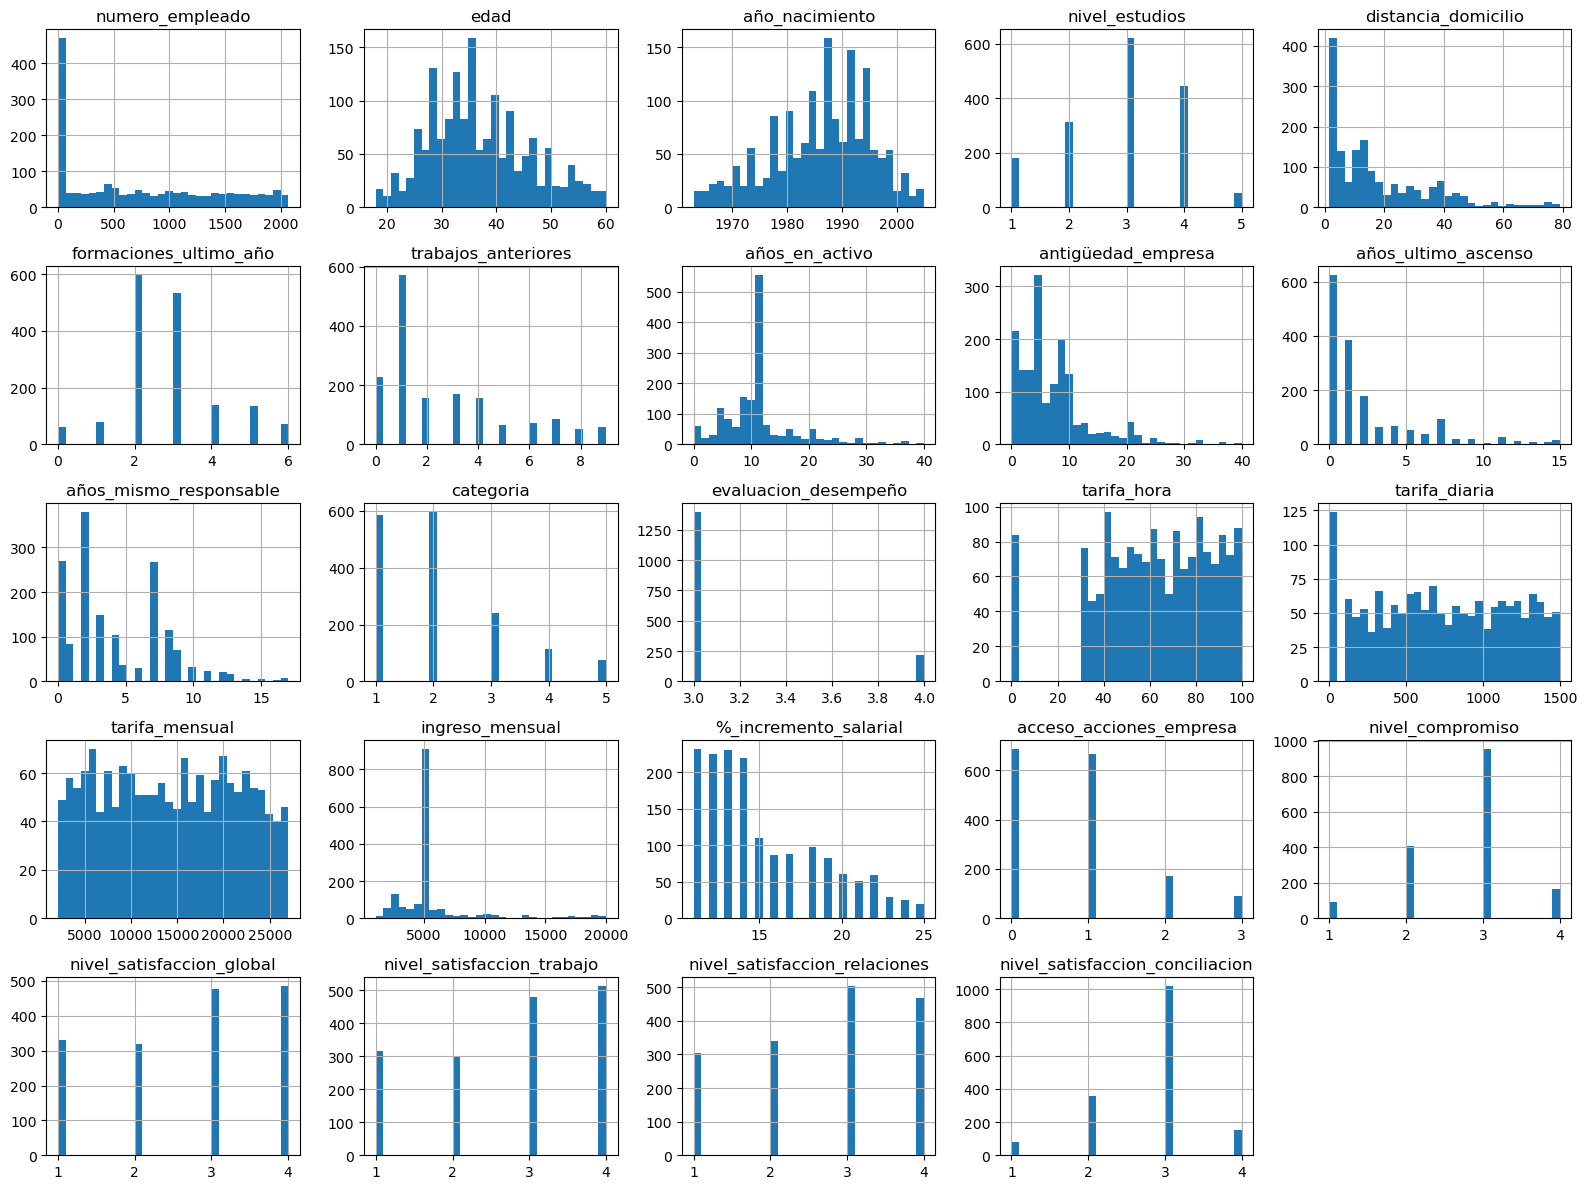

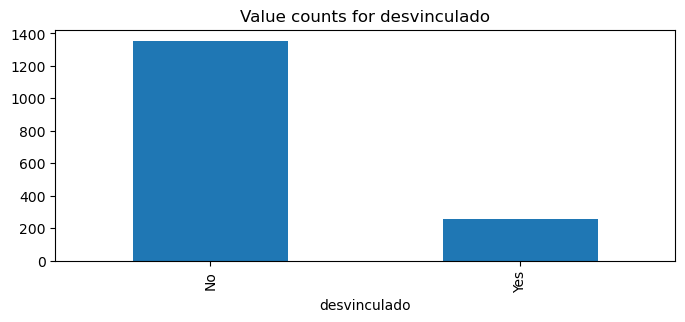

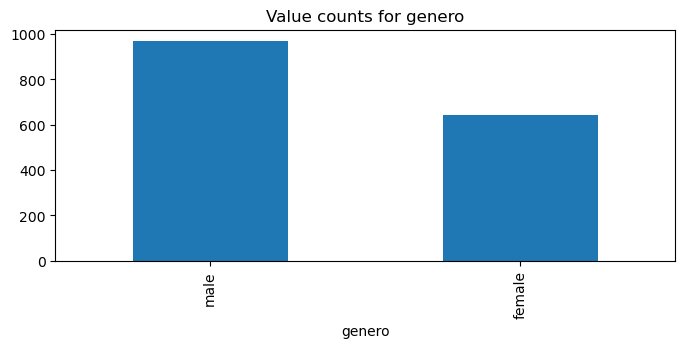

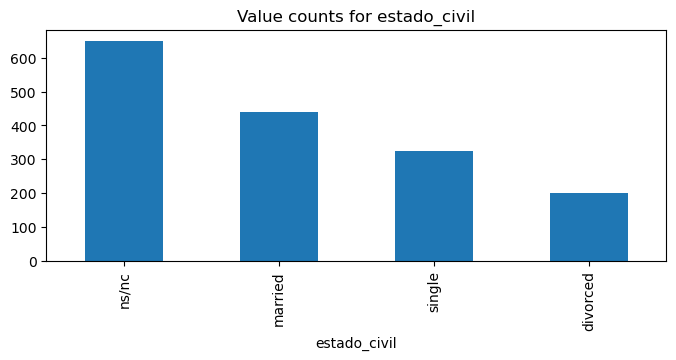

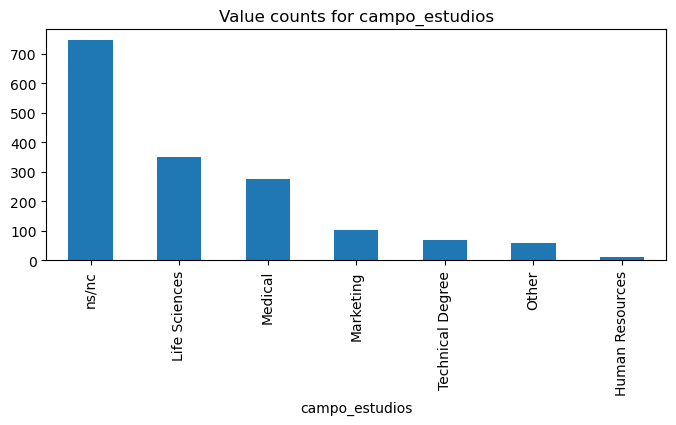

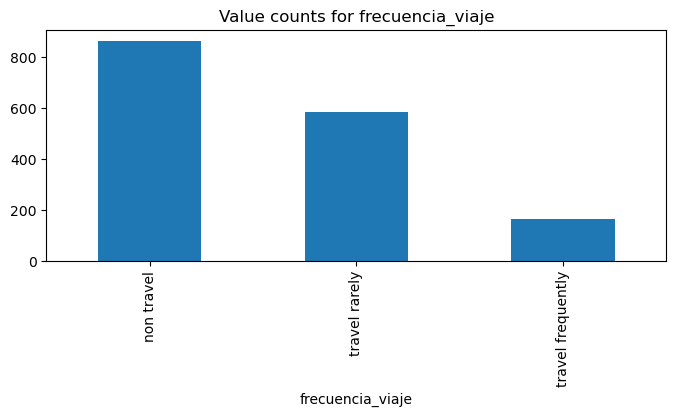

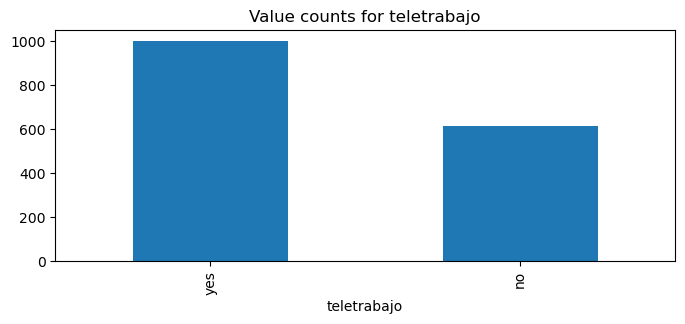

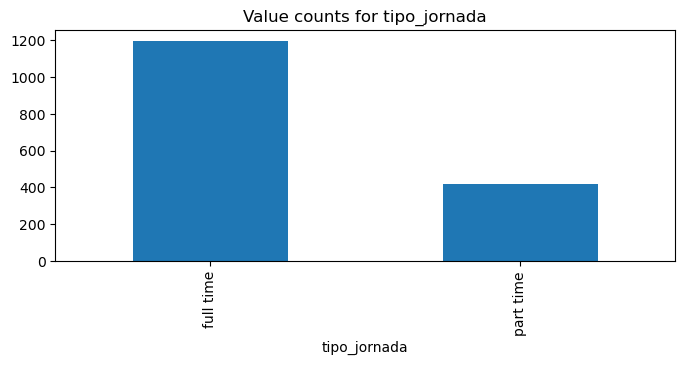

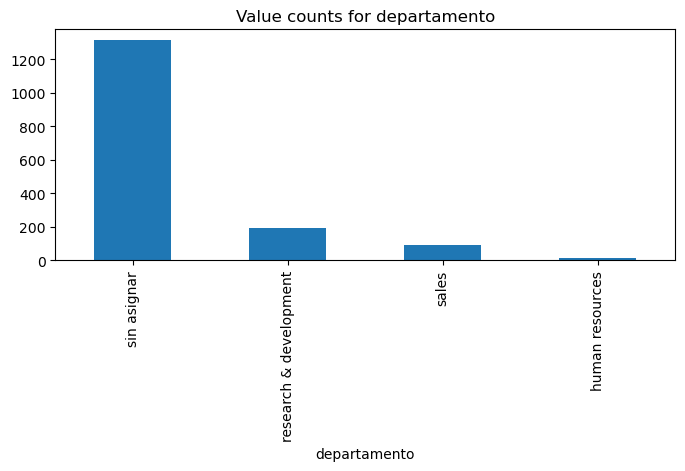

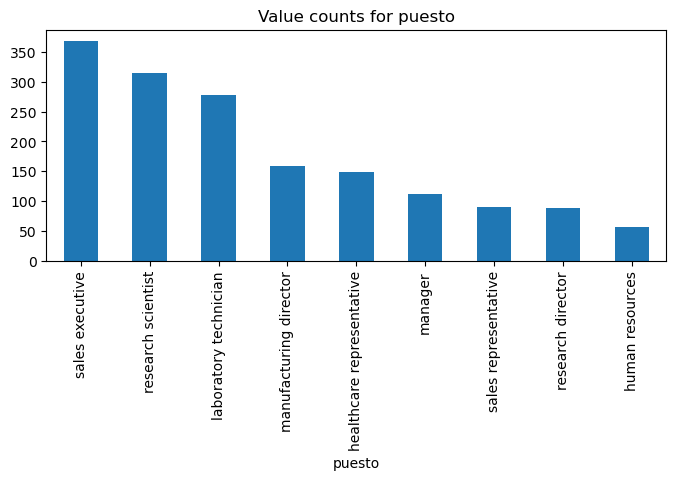

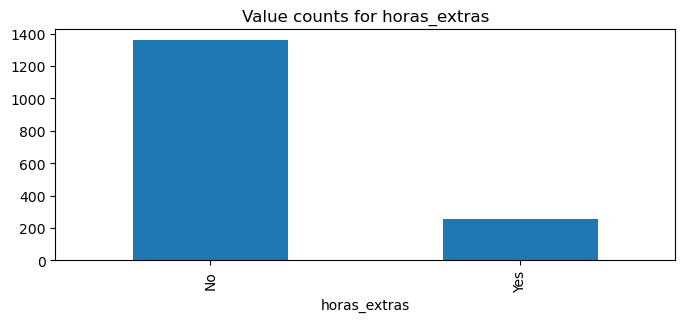

In [4]:
# Histograms for numeric columns
df.select_dtypes(include=[np.number]).hist(figsize=(16,12), bins=30)
plt.tight_layout()
plt.show()


# Bar plots for categorical columns
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    plt.figure(figsize=(8,3))
    df[col].value_counts(dropna=False).plot(kind='bar')
    plt.title(f'Value counts for {col}')
    plt.show()

    

🧠 1. ¿Se están yendo los empleados menos satisfechos?

Dejamos la consulta, ya que puede ser interesante analizar si las personas que se han ido son trabajadores que a la empresa le interesaba tener o no. 

* Consulta: ¿Se van quienes tienen alta evaluación, compromiso o satisfacción?
* Variables: desvinculado, nivel_compromiso, nivel_satisfaccion_global,nivel satisfaccion trabajo.
* ✅ Gráfico: Boxplot: Comparar niveles de desempeño/satisfacción entre empleados activos vs. desvinculados.
    
    



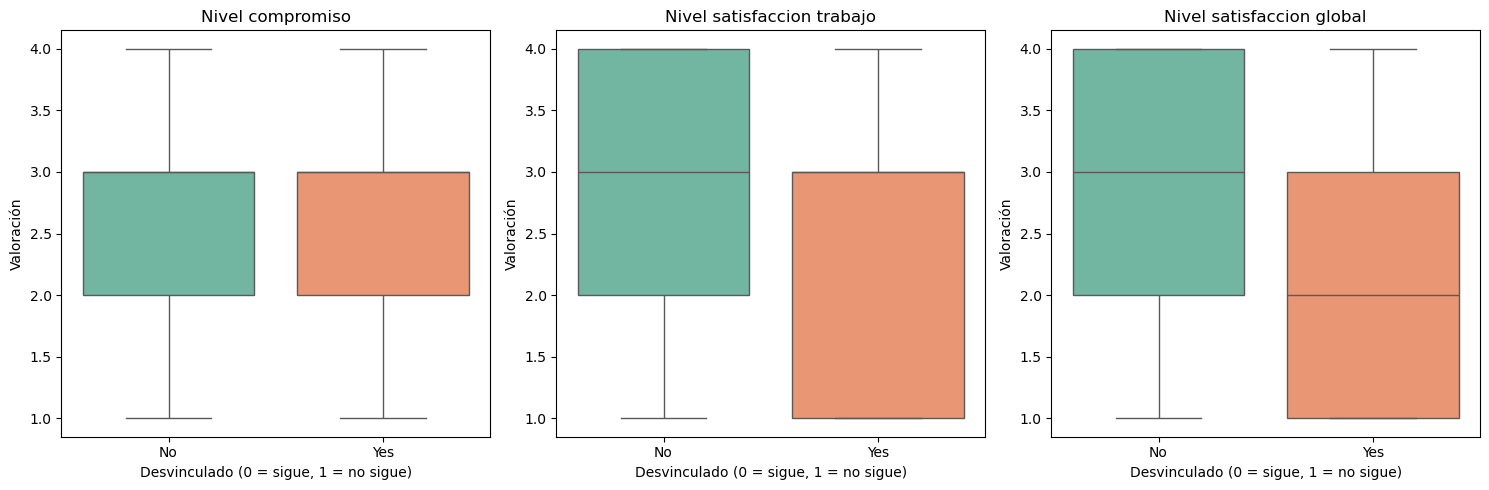

In [5]:
cols_valoracion = ['nivel_compromiso', 'nivel_satisfaccion_trabajo', 'nivel_satisfaccion_global']
plt.figure(figsize=(15, 5))
for i, col in enumerate(cols_valoracion):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(x='desvinculado', y=col, hue='desvinculado', data=df, palette='Set2', legend=False)
    plt.title(f'{col.replace("_", " ").capitalize()}')
    plt.xlabel('Desvinculado (0 = sigue, 1 = no sigue)')
    plt.ylabel('Valoración')
plt.tight_layout()
plt.show()

💸 2. ¿Existe una brecha entre desempeño y compensación?

* Consulta: ¿Cobran menos quienes rinden más? ¿Se van?
* Variables: evaluacion_desempeño, ingreso_mensual, desvinculado
* ✅ Gráfico sugerido:
    * Scatterplot: evaluacion_desempeño vs. ingreso_mensual, coloreado por desvinculado.
    * Heatmap de correlaciones entre variables salariales y de desempeño.



In [6]:
df[['desvinculado','evaluacion_desempeño','ingreso_mensual']]

,desvinculado,evaluacion_desempeño,ingreso_mensual
0,No,3.0,19537.0
1,No,3.0,19999.0
2,No,3.0,19232.0
3,No,3.0,17169.0
4,No,3.0,4859.0
5,No,3.0,17174.0
6,No,3.0,4859.0
7,No,4.0,4859.0
8,No,3.0,16595.0
9,No,3.0,4859.0


In [41]:
df_ingreso= df.groupby('desvinculado')['ingreso_mensual'].mean().round(2)
df_ingreso

desvinculado
No     5788.42
Yes    4815.15
Name: ingreso_mensual, dtype: float64

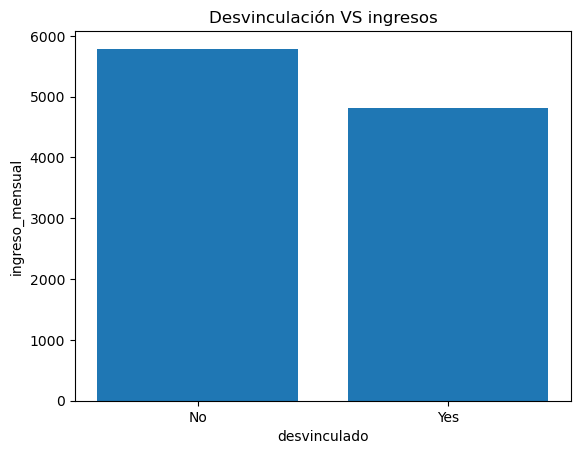

In [45]:
plt.bar(x=df_ingreso.index, height=df_ingreso.values)
plt.xlabel('desvinculado')
plt.ylabel('ingreso_mensual')
plt.title('Desvinculación VS ingresos')
plt.show()

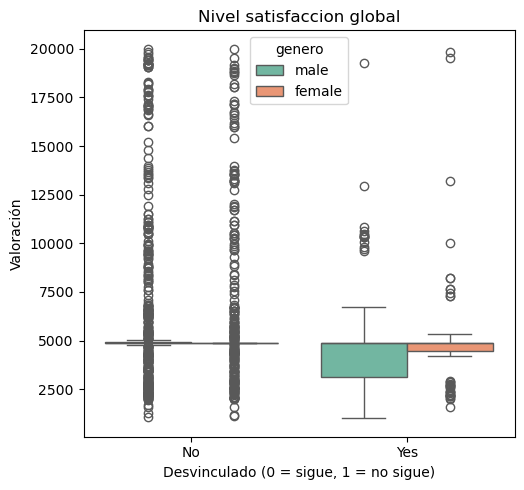

In [10]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, i + 1)
sns.boxplot(x='desvinculado', y='ingreso_mensual', hue='genero', data=df, palette='Set2', legend=True)
plt.title(f'{col.replace("_", " ").capitalize()}')
plt.xlabel('Desvinculado (0 = sigue, 1 = no sigue)')
plt.ylabel('Valoración')

plt.tight_layout()
plt.show()

🧭 3. ¿La movilidad interna reduce la desvinculación?

* Consulta: ¿Se quedan más quienes han sido promovidos o cambiaron de jefe?
* Variables: años_ultimo_ascenso, años_mismo_responsable, desvinculado
* ✅ Gráfico: gráfico de barras.


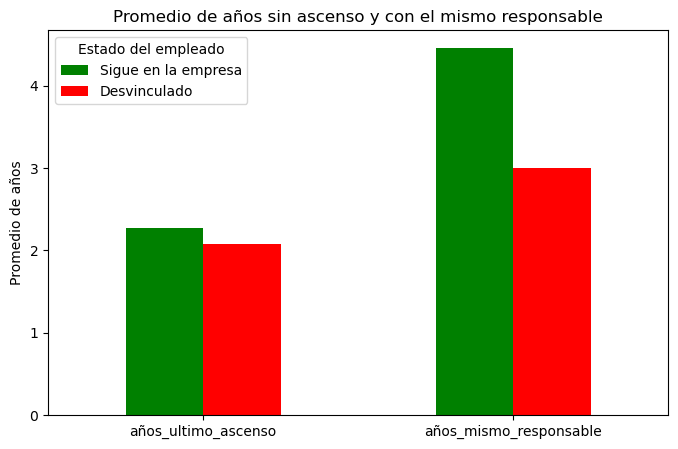

In [11]:
df_grouped = df.groupby('desvinculado')[['años_ultimo_ascenso', 'años_mismo_responsable']].mean().T
# Renombrar columnas para claridad
df_grouped.columns = ['Sigue en la empresa', 'Desvinculado']
# Gráfico de barras
df_grouped.plot(kind='bar', figsize=(8, 5), color=['green', 'red'])
plt.title('Promedio de años sin ascenso y con el mismo responsable')
plt.ylabel('Promedio de años')
plt.xticks(rotation=0)
plt.legend(title='Estado del empleado')
plt.show()

 4. ¿Hay perfiles tipo de desvinculación? (clustering opcional) (ALMU)

* Consulta: ¿Podemos agrupar empleados por comportamiento y ver quiénes se van?
* Variables sugeridas para cluster: edad, nivel_estudios, formaciones_ultimo_año, nivel_satisfaccion_trabajo, etc.
* ✅ Gráfico sugerido:
    * PCA + Scatterplot (si haces clustering con KMeans) coloreado por desvinculado.
    * Dendrograma (si haces clustering jerárquico).



In [14]:
df.dtypes

numero_empleado                    float64
desvinculado                        object
genero                              object
edad                                 int64
año_nacimiento                       int64
estado_civil                        object
nivel_estudios                       int64
campo_estudios                      object
frecuencia_viaje                    object
distancia_domicilio                float64
teletrabajo                         object
tipo_jornada                        object
formaciones_ultimo_año               int64
trabajos_anteriores                  int64
años_en_activo                     float64
antigüedad_empresa                   int64
años_ultimo_ascenso                  int64
años_mismo_responsable               int64
departamento                        object
categoria                            int64
puesto                              object
horas_extras                        object
evaluacion_desempeño               float64
tarifa_hora

📉 5. ¿Se van por falta de conciliación? (AURIS) 

* Consulta: ¿A menor conciliación, mayor fuga?
* Variables: nivel_satisfaccion_conciliacion, tipo_jornada, teletrabajo, desvinculado
* ✅ Gráfico sugerido:
    * Bar chart agrupado: conciliación vs. desvinculación, por tipo de jornada o modalidad de trabajo.
    * Boxplot: conciliación entre activos vs. desvinculados.



C:\Users\ceo\AppData\Local\Temp\ipykernel_35860\3628214678.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


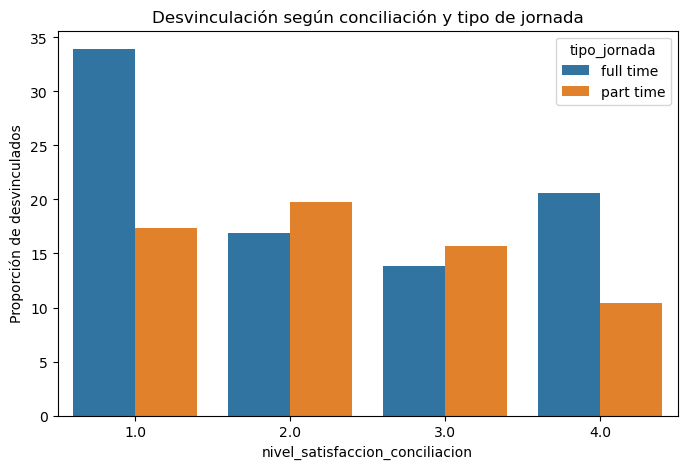

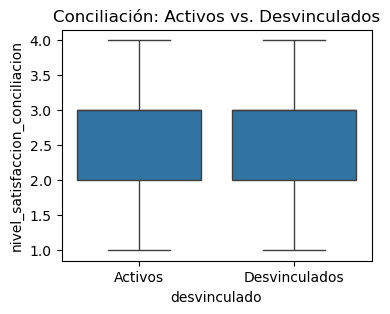

In [20]:
df = df.dropna(subset=['nivel_satisfaccion_conciliacion', 'desvinculado', 'tipo_jornada', 'teletrabajo'])
# Asegúrate de que las variables sean del tipo correcto
df['desvinculado'] = df['desvinculado'].replace({'Yes': 1, 'No': 0}).astype(int)
df['nivel_satisfaccion_conciliacion'] = pd.to_numeric(df['nivel_satisfaccion_conciliacion'], errors='coerce')
df['desvinculado'] = df['desvinculado'].astype(int)
# 1. Bar chart agrupado
plt.figure(figsize=(8,5))
sns.barplot(
    data=df,
    x='nivel_satisfaccion_conciliacion',
    y='desvinculado',
    hue='tipo_jornada',  # O usa 'teletrabajo'
    estimator=lambda x: sum(x)/len(x)*100,  # Proporción de desvinculados
    ci=None
)
plt.ylabel('Proporción de desvinculados')
plt.title('Desvinculación según conciliación y tipo de jornada')
plt.show()
# 2. Boxplot
plt.figure(figsize=(4,3))
sns.boxplot(
    data=df,
    x='desvinculado',
    y='nivel_satisfaccion_conciliacion'
)
plt.xticks([0,1], ['Activos', 'Desvinculados'])
plt.title('Conciliación: Activos vs. Desvinculados')
plt.show()


💥 6. ¿Se quema el talento senior? (SILVIA)

* Consulta: ¿Se van quienes llevan muchos años sin ascender?
* Variables: años_en_activo, antigüedad_empresa, años_ultimo_ascenso, desvinculado
* ✅ Gráfico sugerido:
    * Scatterplot 3D (si quieres sorprender): eje X = antigüedad, eje Y = ascenso, color = desvinculado.
        * Bar chart: porcentaje de desvinculados según tramos de antigüedad y promociones.



C:\Users\ceo\AppData\Local\Temp\ipykernel_35860\1958285144.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="desvinculado", y=col, ax=axes[i], palette="Set2")
C:\Users\ceo\AppData\Local\Temp\ipykernel_35860\1958285144.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(["No", "Sí"])  # opcional, para que sea más claro
C:\Users\ceo\AppData\Local\Temp\ipykernel_35860\1958285144.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="desvinculado", y=col, ax=axes[i], palette="Set2")
C:\Users\ceo\AppData\Local\Temp\ipykernel_35860\1958285144.py:10: UserWarning: set

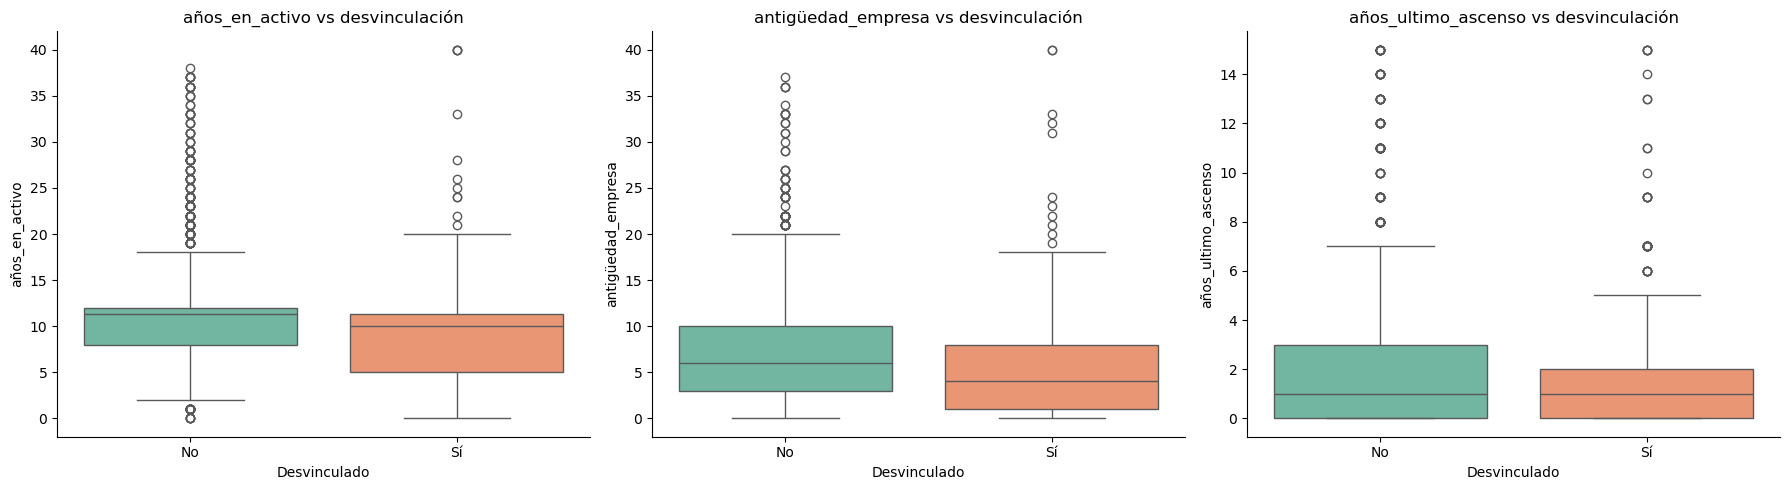

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

columnas = ["años_en_activo", "antigüedad_empresa", "años_ultimo_ascenso"]

for i, col in enumerate(columnas):
    sns.boxplot(data=df, x="desvinculado", y=col, ax=axes[i], palette="Set2")
    axes[i].set_title(f'{col} vs desvinculación')
    axes[i].set_xlabel("Desvinculado")
    axes[i].set_ylabel(col)
    axes[i].set_xticklabels(["No", "Sí"])  # opcional, para que sea más claro
    axes[i].spines[['right', 'top']].set_visible(False)

plt.tight_layout()
plt.show()

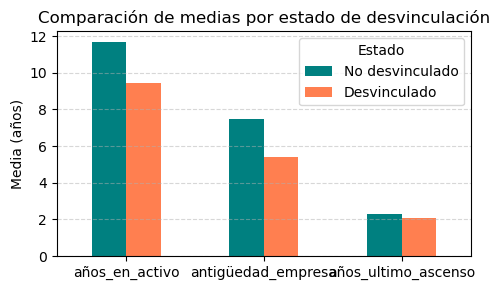

In [41]:
medias = df.groupby("desvinculado")[["años_en_activo", "antigüedad_empresa", "años_ultimo_ascenso"]].mean().T
medias.columns = ["No desvinculado", "Desvinculado"]

medias.plot(kind='bar', figsize=(5,3), color=["teal", "coral"])

plt.title("Comparación de medias por estado de desvinculación")
plt.ylabel("Media (años)")
plt.xticks(rotation=0)
plt.legend(title="Estado", loc="upper right")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

🧩 7. ¿Qué pesa más para irse: emoción o racionalidad? (LUCIA)

* Consulta: Comparar impacto de factores emocionales vs. racionales.
* Variables:
    * Emocionales: nivel_satisfaccion_conciliacion, nivel_satisfaccion_relaciones
    * Racionales: salario, formaciones, ascensos
* ✅ Gráfico sugerido: decidir qué gráfico es el más apto para plasmar esta consulta. 
    * Bar chart comparativo con impacto de cada variable en la tasa de desvinculación.

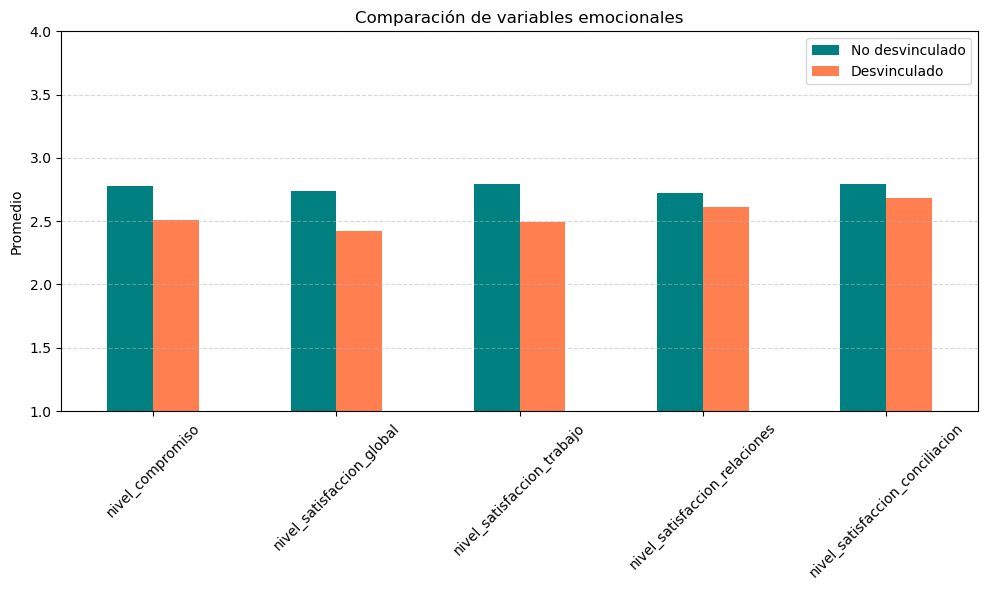

In [39]:
variables_emocionales = ['nivel_compromiso', 'nivel_satisfaccion_global', 'nivel_satisfaccion_trabajo', 'nivel_satisfaccion_relaciones','nivel_satisfaccion_conciliacion']
df_emocionales = (df.groupby('desvinculado')[variables].mean()).round(2).T
df_emocionales.columns = ["No desvinculado", "Desvinculado"]

df_emocionales.plot(kind='bar', figsize=(10,6), color=["teal", "coral"])

plt.title("Comparación de variables emocionales")
plt.ylabel("Promedio")
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.ylim([1,4])
plt.show()

In [27]:
variables.head()

,nivel_satisfaccion_conciliacion,nivel_satisfaccion_relaciones,formaciones_ultimo_año,años_ultimo_ascenso,ingreso_mensual
0,3.0,3,5,15,19537.0
1,3.0,1,5,11,19999.0
2,3.0,4,3,11,19232.0
3,3.0,2,2,5,17169.0
4,3.0,4,5,2,4859.0


In [43]:
numericas = df.select_dtypes(include="number").columns
df_correlation = df[numericas].corr()
df_correlation

,numero_empleado,edad,año_nacimiento,nivel_estudios,distancia_domicilio,formaciones_ultimo_año,trabajos_anteriores,años_en_activo,antigüedad_empresa,años_ultimo_ascenso,años_mismo_responsable,categoria,evaluacion_desempeño,tarifa_hora,tarifa_diaria,tarifa_mensual,ingreso_mensual,%_incremento_salarial,acceso_acciones_empresa,nivel_compromiso,nivel_satisfaccion_global,nivel_satisfaccion_trabajo,nivel_satisfaccion_relaciones,nivel_satisfaccion_conciliacion
numero_empleado,1.000000,0.001270,-0.001161,0.023522,0.023153,0.032204,-0.035173,-0.019887,-0.042063,-0.030221,-0.037282,-0.023853,-0.002556,0.012930,-0.026208,-0.003821,-0.046096,-0.002470,0.031389,-0.026428,0.015803,-0.020900,-0.014537,0.021771
edad,0.001270,1.000000,-0.999907,0.201159,-0.014254,-0.031561,0.289232,0.555229,0.314031,0.217460,0.195964,0.507723,0.000597,0.012125,-0.006517,0.031335,0.329297,0.007022,0.039722,0.036440,0.003602,-0.010496,0.056127,-0.025662
año_nacimiento,-0.001161,-0.999907,1.000000,-0.201536,0.014293,0.031776,-0.289166,-0.555638,-0.313718,-0.217243,-0.195674,-0.507748,-0.000464,-0.011937,0.006083,-0.031665,-0.329182,-0.006728,-0.039405,-0.036568,-0.003697,0.010725,-0.056541,0.026052
nivel_estudios,0.023522,0.201159,-0.201536,1.000000,-0.011657,-0.039725,0.116021,0.123134,0.070010,0.064238,0.068201,0.100346,-0.035674,0.010845,0.000798,-0.028044,0.050048,-0.009138,0.012767,0.043048,-0.042834,-0.006928,-0.017287,0.021237
distancia_domicilio,0.023153,-0.014254,0.014293,-0.011657,1.000000,-0.056699,0.019662,-0.025430,-0.020923,-0.020517,-0.012609,-0.000410,0.024063,0.000171,-0.022903,-0.008280,-0.050603,0.051245,0.044495,0.006721,0.035001,0.027137,-0.005847,-0.033752
formaciones_ultimo_año,0.032204,-0.031561,0.031776,-0.039725,-0.056699,1.000000,-0.080868,-0.063011,0.008089,-0.004501,0.008678,-0.026059,-0.025763,-0.004428,0.002342,-0.000183,-0.009970,-0.006836,0.007315,-0.012010,-0.041193,0.003339,-0.002980,0.018330
trabajos_anteriores,-0.035173,0.289232,-0.289166,0.116021,0.019662,-0.080868,1.000000,0.211779,-0.129465,-0.045365,-0.119690,0.143060,-0.005196,-0.000678,0.052761,0.026566,0.082793,-0.003378,0.039339,0.026374,-0.001402,-0.054967,0.060352,-0.012054
años_en_activo,-0.019887,0.555229,-0.555638,0.123134,-0.025430,-0.063011,0.211779,1.000000,0.517137,0.356517,0.378849,0.625830,-0.007799,0.028540,0.030169,0.036918,0.416420,-0.034854,0.046074,0.020024,0.015467,-0.024281,0.023594,-0.014257
antigüedad_empresa,-0.042063,0.314031,-0.313718,0.070010,-0.020923,0.008089,-0.129465,0.517137,1.000000,0.611809,0.757118,0.532415,-0.006677,0.032474,-0.032830,-0.024277,0.408272,-0.041213,0.013781,-0.015409,0.012143,-0.006868,0.010249,-0.000743
años_ultimo_ascenso,-0.030221,0.217460,-0.217243,0.064238,-0.020517,-0.004501,-0.045365,0.356517,0.611809,1.000000,0.500933,0.342889,0.023926,0.039024,-0.014559,-0.000266,0.230145,-0.022511,0.017034,-0.015804,0.018374,-0.017183,0.027937,0.003949


Text(345.58159722222223, 0.5, 'Nombre del eje Y')

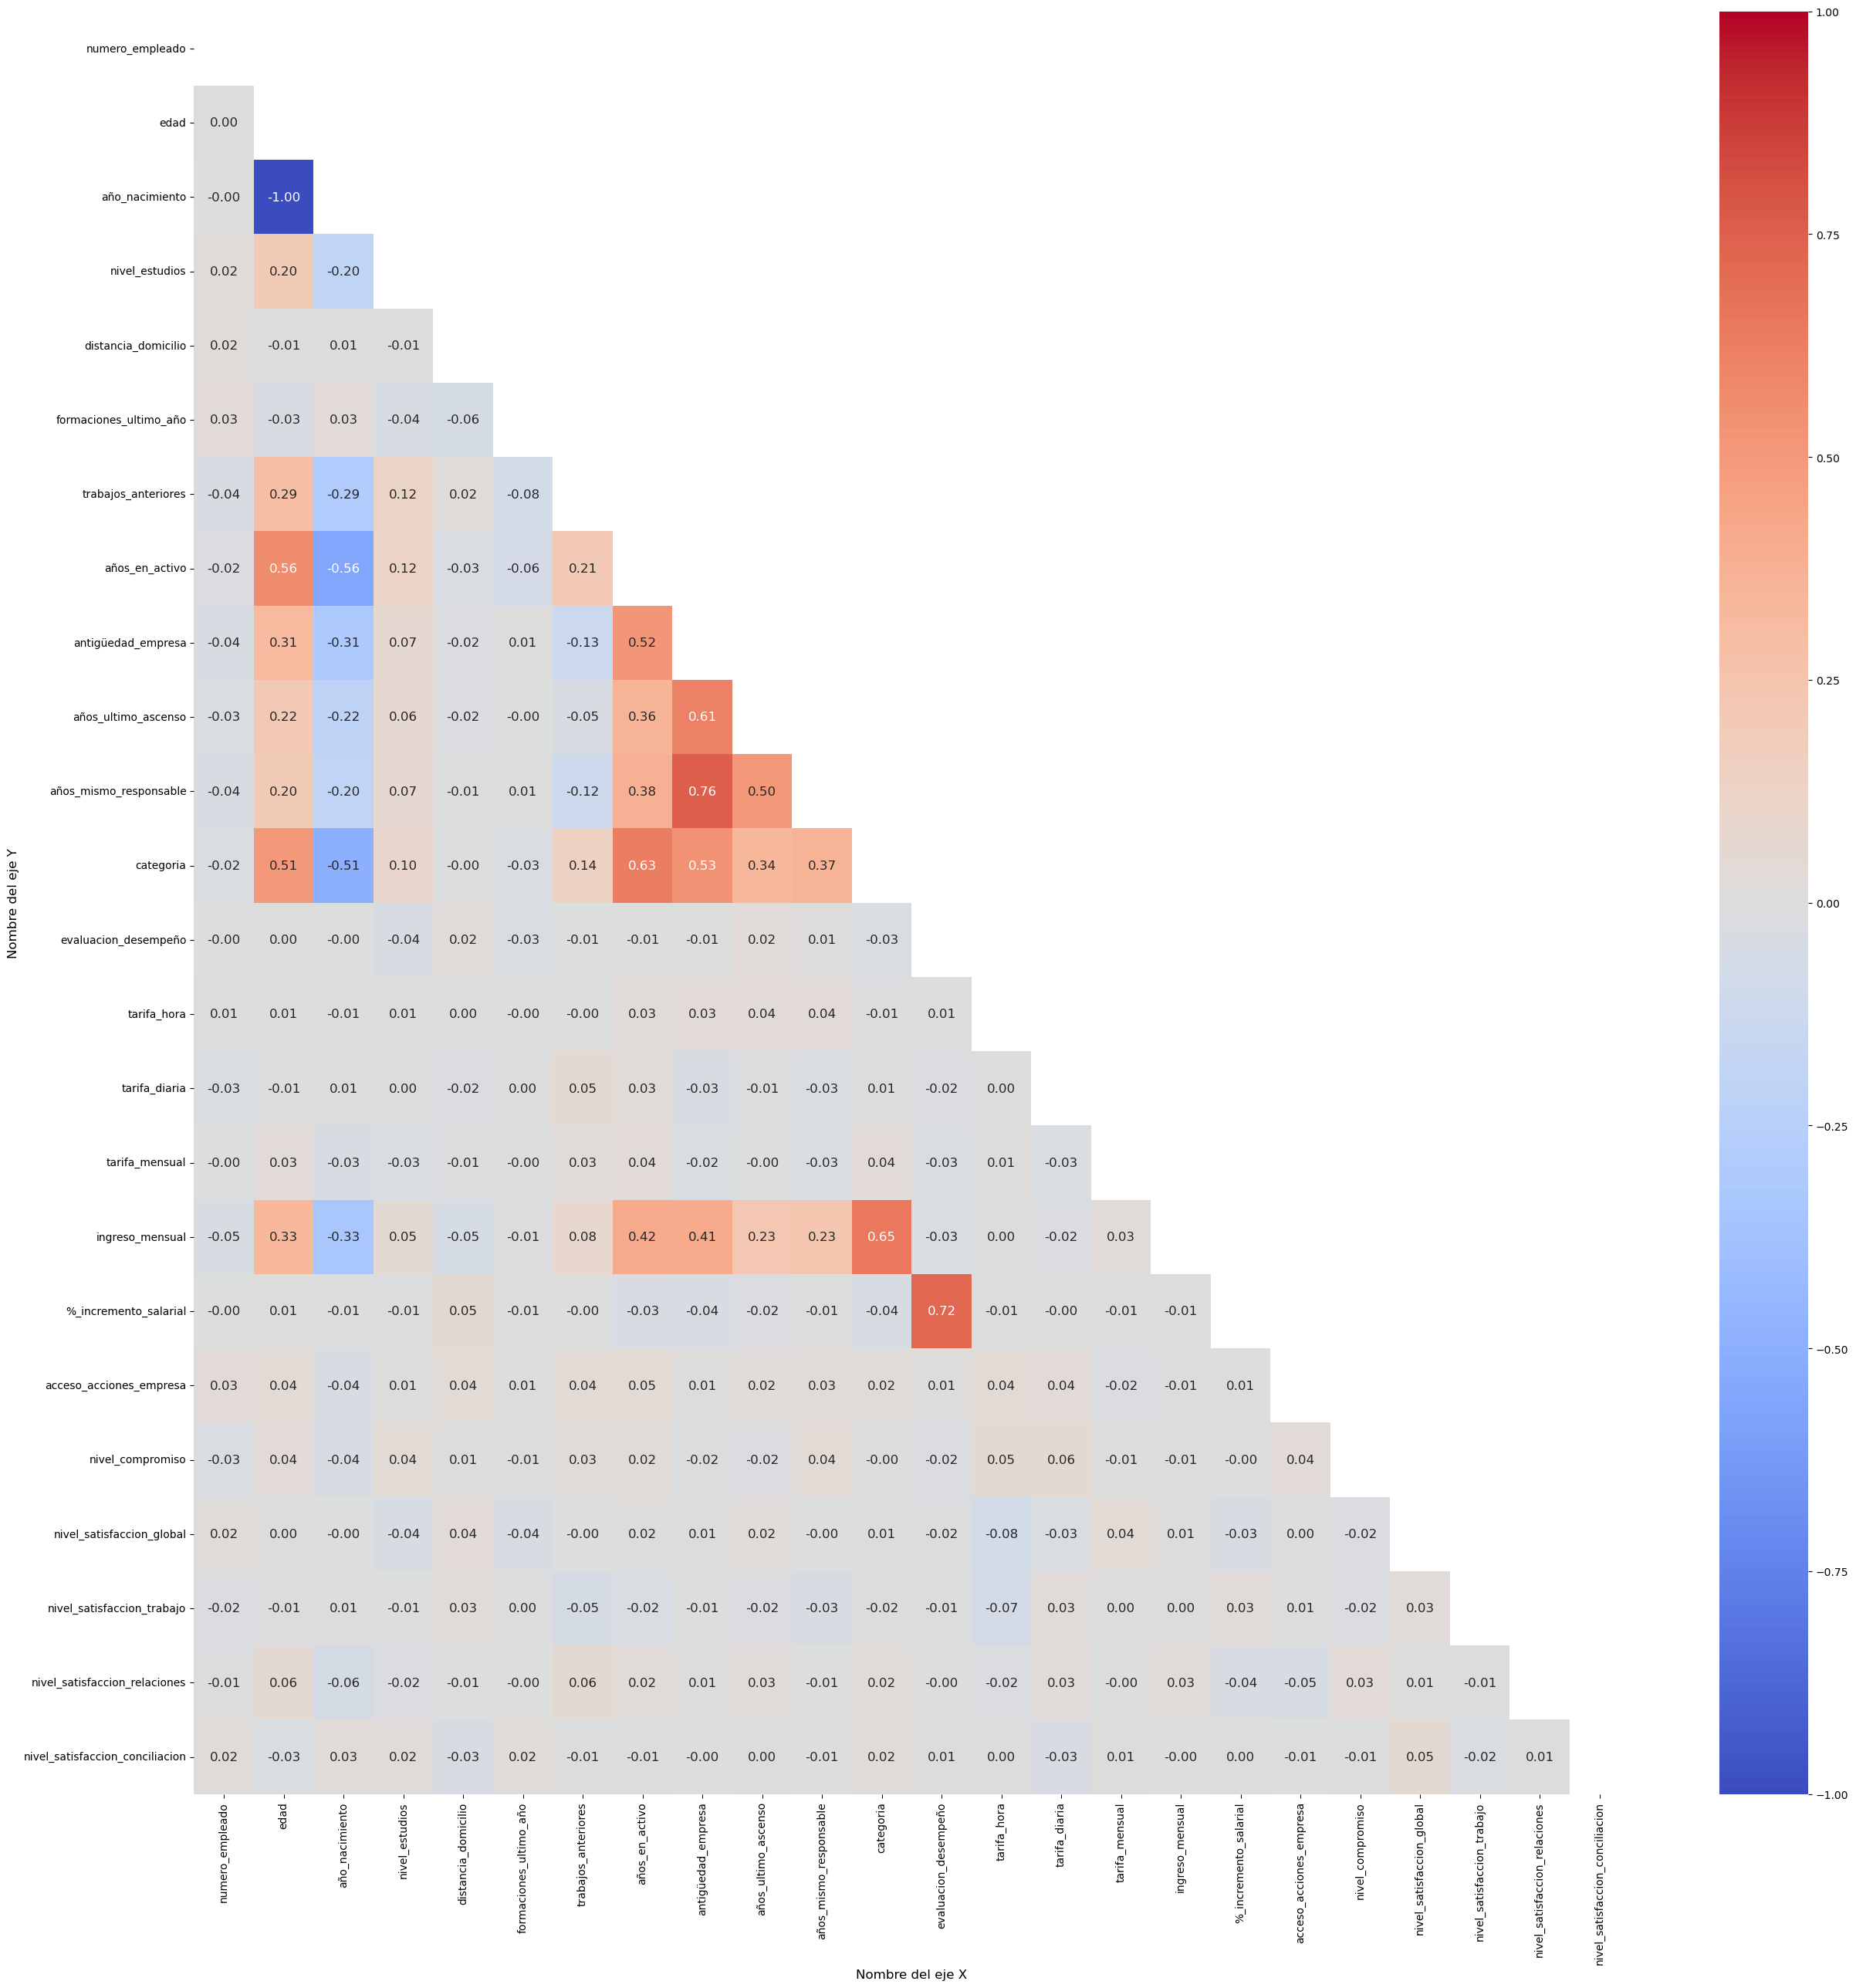

In [49]:
plt.figure(figsize = (30, 30))
mask = np.triu(np.ones_like(df_correlation, dtype=bool)) # creamos una matriz booleana de máscara
sns.heatmap(df_correlation, # creamos un heatmap con la máscara
            annot = True, 
            fmt = ".2f", 
            cmap = "coolwarm", 
            vmax = 1, 
            vmin = -1, 
            mask = mask, 
            annot_kws={"size": 12}); 
plt.xlabel("Nombre del eje X", fontsize=12)
plt.ylabel("Nombre del eje Y", fontsize=12)